## (0) Import Packages

In [1]:
import sys
sys.path.append('../src/') 
import numpy as np
import torch
import Core as C
import math
import pickle
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload

In [3]:
autoreload

## (1) Load Data and Batch Data

In [26]:
# Unpickle file
with open('./Pickle_storage/test_data_tokenized_WA.pkl', 'rb') as handle:
    data, embed_map = pickle.load(handle) # We stored the data and embedding map in one file
with open('./Pickle_storage/train_data_tokenized.pkl', 'rb') as handle:
    data_train, embed_map_train = pickle.load(handle) # We stored the data and embedding map in one file

# Visualize data
len(pd.DataFrame(data)['labels'][8])
pd.DataFrame(data).keys()

Index(['accession_id', 'aligned_seqs', 'scores', 'labels', 'numerical_tokens'], dtype='object')

In [5]:
pd.DataFrame(data).head()

,accession_id,aligned_seqs,scores,labels,numerical_tokens
0,EU100698,ATGAG-GACTATCA-T--TGCTTTGAGCTA-CATT-CTA-T-GTCT...,1169.0,"[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, ...","[0, 2, 3, 0, 3, 4, 3, 0, 1, 2, 0, 2, 1, 0, 4, ..."
1,EU199367,ATGA-AGACTATCA-T--TGCTTTGAGCTA-CATT-CTA-T-GTCT...,1169.0,"[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, ...","[0, 2, 3, 0, 4, 0, 3, 0, 1, 2, 0, 2, 1, 0, 4, ..."
2,CY026603,TATTAACC--ATGAAGACTATCAT-TGCTTTGAGCTA-CATT-CTA...,1172.0,"[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, ...","[2, 0, 2, 2, 0, 0, 1, 1, 4, 4, 0, 2, 3, 0, 0, ..."
3,CY026771,TTCTATTAACC--ATGAAGACTATCAT-TGCTTTGAGCTA-CATT-...,1171.0,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, ...","[2, 2, 1, 2, 0, 2, 2, 0, 0, 1, 1, 4, 4, 0, 2, ..."
4,EU516081,ATGAA-AG-TA-AAACTAC-TGGTCC-T--G-T-T-AT-GC-A-CA...,1171.0,"[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...","[0, 2, 3, 0, 0, 4, 0, 3, 4, 2, 0, 4, 0, 0, 0, ..."


In [27]:
%%time
# Create embedding and batch data
ds_test = C.dataset.Dataset(data, embed=embed_map)
#ds_test.drop_dashes()
ds_test.make_subseqs(length=200)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256, pin_memory=True)  # The data loader

ds_train = C.dataset.Dataset(data_train, embed=embed_map)
#ds_train.drop_dashes()
ds_train.make_subseqs(length=200)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=256, pin_memory=True)  # The data loader


CPU times: user 21.2 s, sys: 1.18 s, total: 22.3 s
Wall time: 22.3 s


In [28]:
sum([math.floor(len(dl_train)*0.8), math.floor(len(dl_train)*0.2)])

4163

In [29]:
len(ds_train.subseq_data)

1065828

In [30]:
# Train/Val Split
train_data, val_data = torch.utils.data.random_split(
    dl_train, [math.floor(len(dl_train)*0.9), math.floor(len(dl_train)*0.1)+1])

## (2) Define Model

In [31]:
class TransformerModel(torch.nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super().__init__()
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.encoder = torch.nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = torch.nn.Linear(ninp, 2)
        self.softmax = torch.nn.Softmax(dim=2)

        self.init_weights()

    @staticmethod
    def generate_square_subsequent_mask(sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        output = self.softmax(output)
        return output


class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## (3) Define Hyperparameters and setup logging

In [32]:
from torch.utils.tensorboard import SummaryWriter

In [33]:
ntokens = len(embed_map) # the size of vocabulary
emsize = 4 # embedding dimension
nhid = 10 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 3 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to('cuda')
writer = SummaryWriter(log_dir='./TBlogs/Test1', flush_secs=60)
cur_batch = 0

In [34]:
!mkdir ./TBlogs/Test1

mkdir: cannot create directory ‘./TBlogs/Test1’: File exists


In [35]:
#Sandbox: Figure out loss function
#src_mask = model.generate_square_subsequent_mask(seq.size(0))
#output = model(seq, src_mask).data.view(-1,2)
#criterion(output,label.view(-1))

## (4) Define Functions for Training and Validation Steps

In [36]:
# Define train and validation functions
criterion = torch.nn.CrossEntropyLoss()
lr = 1e-4 # learning rate
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.8))
#scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda x: 0.99, last_epoch=100)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, threshold=0.0001, 
                                                       patience=30, cooldown=100, min_lr=1e-8)
def train(train_data, epoch_var):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    cur_loss_list = []
    cur_batch = len(train_data.dataset) * epoch_var
    for batch, data in enumerate(train_data.dataset):
        seq, targets = data # embedded sequence, position labels
        #print(seq.shape)
        optimizer.zero_grad()
        seq = seq.cuda()
        targets = targets.cuda()
        src_mask = model.generate_square_subsequent_mask(seq.size(0)).cuda()
        output = model(seq, src_mask).view(-1,2)
        loss = criterion(output, targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        log_interval = 50
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            #elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5d} batches | '
            #      'ms/batch {:5.2f} | '
            #      'loss {:5.4f} | ppl {:8.4f}'.format(
            #        epoch, batch,
            #        elapsed * 1000 / log_interval,
            #        cur_loss, math.exp(cur_loss)))
            total_loss = 0
            #start_time = time.time()
            cur_loss_list.append(cur_loss)
            for pid, parameter in enumerate(model.parameters()):
                writer.add_histogram(f'Weights/{pid}', parameter.grad, global_step=cur_batch)
            writer.add_scalar('Loss/Train', cur_loss, cur_batch)
            scheduler.step(cur_loss)
        cur_batch += 1
    return cur_loss_list

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    
    with torch.no_grad():
        for val_batched in data_source.dataset:
            seq, targets = val_batched
            seq = seq.cuda()
            targets = targets.cuda()
            src_mask = model.generate_square_subsequent_mask(seq.size(0)).cuda()
            output = eval_model(seq, src_mask).cuda().view(-1,2)
            # Calculate loss: Might need a better way
            total_loss += criterion(output, targets.view(-1)).item()
    return total_loss / (len(data_source) -1)

## (5) Train Model

In [ ]:
%%time
# Train model
best_val_loss = float(0)
epochs = 300 # The number of epochs
best_model = None
big_loss_list = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    big_loss_list.append(train(train_data, epoch-1))  # returns performance metrics
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.5f}s | valid loss {:5.5f} '
          .format(epoch, (time.time() - epoch_start_time),
                                     val_loss))
    print('-' * 80)
    writer.add_scalar('Loss/Val', val_loss, epoch)
    if val_loss > best_val_loss:
        best_val_loss = val_loss
        best_model = model
    if epoch % 1 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, f'./ModelSaves/Save-{epoch}-v2.pt')
writer.close()

-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 248.66757s | valid loss 5.54663 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 249.18204s | valid loss 5.52466 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 247.98830s | valid loss 5.52128 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 248.08887s | valid loss 5.52086 
--------------------------------------------------------------------------------
----------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  37 | time: 248.38199s | valid loss 5.52073 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  38 | time: 247.89317s | valid loss 5.52073 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  39 | time: 248.44257s | valid loss 5.52073 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  40 | time: 249.08768s | valid loss 5.52073 
--------------------------------------------------------------------------------
----------------------------------------------------------------------------

-----------------------------------------------------------------------------------------
| end of epoch  73 | time: 248.42454s | valid loss 5.52069 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  74 | time: 248.31344s | valid loss 5.52068 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  75 | time: 248.82710s | valid loss 5.52068 
--------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch  76 | time: 246.80403s | valid loss 5.52068 
--------------------------------------------------------------------------------
----------------------------------------------------------------------------

In [19]:
writer.close()

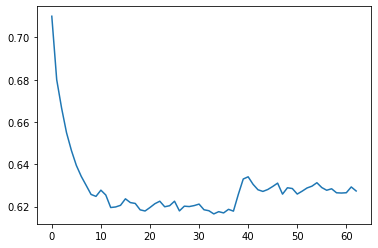

In [17]:
plt.plot(big_loss_list[0])